# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from copy import deepcopy
from random import shuffle
from sklearn.manifold import TSNE

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
                                        

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
dataset = trainset.data / 255 
mean = dataset.mean(axis = (0,1,2)) 
std = dataset.std(axis = (0,1,2))

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [ ]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, (train_size, val_size))

In [ ]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=2*batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2*batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

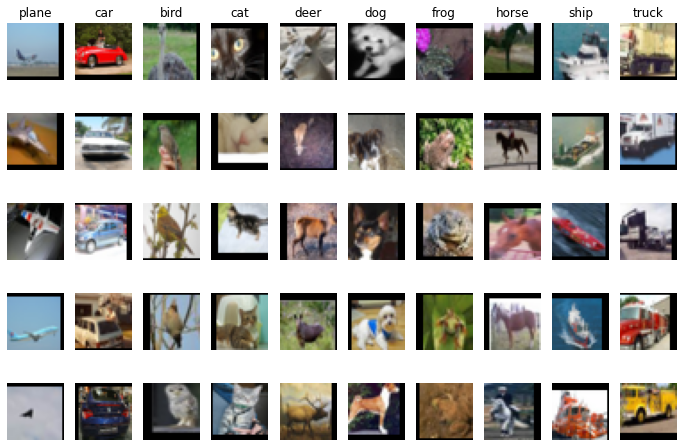

In [ ]:
images = []
i = 0
n = 5
k = 10

for i in range(len(classes)):
    images.append([])

while sum(len(x) for x in images) < len(classes) * k * n:
    img, label = trainset[i]
    if len(images[label]) < k*n :
        images[label].append(img)
    i += 1

for i in range(len(classes)):
  shuffle(images[i])

fig, axes = plt.subplots(nrows=n, ncols=len(classes), figsize=(12, 8))
# or 20, 4

for ax, col in zip(axes[0], classes):
    ax.set_title(col)
    
for i in range(len(classes)):
    for j in range(n):
        img_np = images[i][j].permute(1, 2, 0).numpy()
        img_np = img_np * std + mean
        axes[j][i].imshow(img_np)
        axes[j][i].axis('off')

plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

*The following model is used*

![Original-ResNet-18-Architecture.png](https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)


*A smaller version of the above model is used to avoid over fitting. Batchnorm and Dropout are also added for the same reason.*

In [ ]:
from re import template
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(             # 3   32  32
            nn.Conv2d(3, 64, 3, padding=1),     # 64  32  32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False)
        )
        
        self.conv2a = nn.Sequential(             # 64  32  32
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(64)
        )
        
        self.conv2b = nn.Sequential(             # 64  32  32
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5)
        )
        
        self.conv3a = nn.Sequential(             # 64  32  32
            nn.Conv2d(64, 128, 3, stride=2, padding=1),    # 128  16  16
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),    # 128  16  16
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(128)
        )
        
        self.conv3b = nn.Sequential(             # 128  16  16
            nn.Conv2d(128, 128, 3, padding=1),    # 128  16  16
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),    # 128  16  16
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5)
        )

        self.conv3a_short = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),    # 128  16  16
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(128)
        )
        
        self.conv4a = nn.Sequential(             # 128  16  16
            nn.Conv2d(128, 256, 3, stride=2, padding=1),    # 256  8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),    # 256  8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(256),
        )
        
        self.conv4b = nn.Sequential(             # 256  8  8
            nn.Conv2d(256, 256, 3, padding=1),    # 128 8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),    # 128  8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5)
        )

        self.conv4a_short = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),    # 128  8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(256)
        )

        self.conv5a = nn.Sequential(             # 128 8  8
            nn.Conv2d(256, 512, 3, stride=2, padding=1),    # 256  4  4
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),    # 256  4  4
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(512),
        )
        
        self.conv5b = nn.Sequential(             # 256  4  4
            nn.Conv2d(512, 512, 3, padding=1),    # 256 4  4
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),    # 256  4  4
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )

        self.conv5a_short = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),    # 128  8  8
            nn.ReLU(inplace=False),
            nn.BatchNorm2d(512)
        )

        self.pool = nn.Sequential(                # 512 4 4
            nn.AvgPool2d(2, stride = 2),          # 512 2 2
            nn.Dropout(0.5),
            nn.Flatten()                          # 8192
        )  
        
        self.maxpool = nn.MaxPool2d(2, 2) 

        self.fc1a = nn.Linear(2048, 400)
        self.fc1b = nn.ReLU(inplace=False)
    
        self.fc2 = nn.Linear(400, 10)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        tmp = x.clone()
        x = self.conv2a(x)
        x = x + tmp
        tmp = x.clone()
        x = self.conv2b(x)
        x = x + tmp
        tmp = x.clone()
        x = self.conv3a(x)
        x = x + self.conv3a_short(tmp)
        tmp = x.clone()
        x = self.conv3b(x)
        x = x + tmp
        tmp = x.clone()
        x = self.conv4a(x)
        x = x + self.conv4a_short(tmp)
        tmp = x.clone()
        x = self.conv4b(x)
        x = x + tmp
        tmp = x.clone()
        x = self.conv5a(x)
        x = x + self.conv5a_short(tmp)
        tmp = x.clone()
        x = self.conv5b(x)
        x = x + tmp
        x = self.pool(x)
        x = self.fc1a(x)
        x = self.fc1b(x)
        x = self.fc2(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet().to(device)
net

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2a): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropo

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
lr = 5e-3
lr_min = 1e-4
weight_decay = 5e-3
momentum = 0.9
sched = True
used_optim = "sgd"
used_sched = "annealing"

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
if used_optim == "adam":
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
else:
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum,
                            weight_decay = weight_decay)
if sched:
  if sched == "annealing":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min = lr_min)
  else:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    train_loss = 0
    train_correct = 0
    train_all = 0
    
    net.train()
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)
        
        loss = criterion(pred, y)
        train_loss += float(loss)

        predictions = pred.argmax(-1)
        train_all += len(predictions)
        train_correct += (predictions == y).sum()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_acc = train_correct / train_all
    
    return train_loss, train_acc

In [ ]:
def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    val_loss = 0
    val_correct = 0
    val_all = 0
    
    net.eval()
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)
        
        loss = criterion(pred, y)
        val_loss += float(loss)

        predictions = pred.argmax(-1)
        val_all += len(predictions)
        val_correct += (predictions == y).sum()
    
    val_acc = val_correct / val_all
    
    return val_loss, val_acc

In [ ]:
load = False

In [ ]:
if load:
  net.load_state_dict(torch.load('resnet_91.pth'))
  print("Model Loaded.")
else:
  epochs = 75
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []

  for i in range(epochs):
      print(f"[Epoch {i}]")
      
      train_loss, train_acc = train_epoch(net, criterion, optimizer, trainloader)
      val_loss, val_acc = eval_epoch(net, criterion, valloader)
      if sched:
        scheduler.step()

      print(f"Train Loss: {train_loss} \t Train Accuracy: {train_acc}")
      print(f"Validation Loss: {val_loss} \t Validation Accuracy: {val_acc}")
      
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc.cpu().data.numpy())
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc.cpu().data.numpy())
  print(f"Training done.")


[Epoch 0]
Train Loss: 277.0383720397949 	 Train Accuracy: 0.34154999256134033
Validation Loss: 29.6109379529953 	 Validation Accuracy: 0.45249998569488525
[Epoch 1]
Train Loss: 213.61751055717468 	 Train Accuracy: 0.49879997968673706
Validation Loss: 24.55902862548828 	 Validation Accuracy: 0.5496999621391296
[Epoch 2]
Train Loss: 178.5955560207367 	 Train Accuracy: 0.5884749889373779
Validation Loss: 21.5407235622406 	 Validation Accuracy: 0.6083999872207642
[Epoch 3]
Train Loss: 156.1948863863945 	 Train Accuracy: 0.6432999968528748
Validation Loss: 19.776444792747498 	 Validation Accuracy: 0.6477000117301941
[Epoch 4]
Train Loss: 137.67594397068024 	 Train Accuracy: 0.6848499774932861
Validation Loss: 17.96576017141342 	 Validation Accuracy: 0.6843999624252319
[Epoch 5]
Train Loss: 122.57812494039536 	 Train Accuracy: 0.7228749990463257
Validation Loss: 15.86085730791092 	 Validation Accuracy: 0.7232999801635742
[Epoch 6]
Train Loss: 109.76404827833176 	 Train Accuracy: 0.7536749839

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

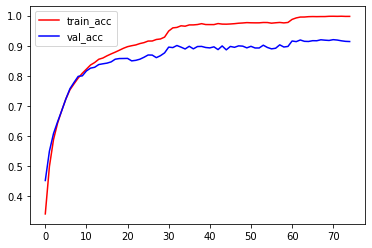

In [ ]:
if not load:
  fig = plt.gcf()
  x = list(range(len(train_acc_list)))
  plt.plot(x, train_acc_list, 'r')
  plt.plot(x, val_acc_list, 'b')  
  plt.legend(['train_acc', 'val_acc'])

  plt.show()
  fig.savefig("acc_plot")
else:
  print("We're in loading mode so no plot!")

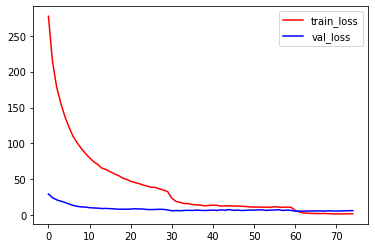

In [ ]:
if not load:
  fig = plt.gcf()
  x = list(range(len(train_acc_list)))
  plt.plot(x, train_loss_list, 'r')
  plt.plot(x, val_loss_list, 'b') 
  plt.legend(['train_loss', 'val_loss']) 

  plt.show()
  fig.savefig("loss_plot")
else:
  print("We're in loading mode so no plot!")

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
test_loss, test_acc = eval_epoch(net, criterion, testloader)
print(f"Test Loss: {test_loss} \t Test Accuracy: {test_acc}")
    

Test Loss: 6.427408143877983 	 Test Accuracy: 0.914900004863739


In [ ]:
if not load:
  torch.save(net.state_dict(), f"resnet_{int(test_acc*100)}.pth") 

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

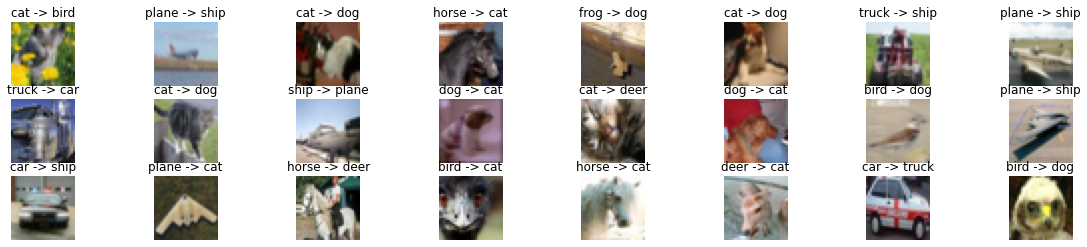

In [ ]:
images = []
labels = []
true_labels = []

n = 24
i = 0

for i, (x,y) in enumerate(testloader):
  if len(images) >= n:
      break
  x = x.to(device)
  y = y.to(device)
  pred = net(x).argmax(-1)
  for i in range(len(pred)):
    if len(images) >= n:
      break
    if pred[i] != y[i]:
      tmp = torch.clone(x[i])
      tmp = tmp.cpu().data
      images.append(tmp)
      labels.append(pred[i])
      true_labels.append(y[i])

temp = list(zip(images, labels, true_labels))
shuffle(temp)
images, labels, true_labels = zip(*temp)

fig = plt.figure(figsize=(20, 4))

for i in range(n):
    fig.add_subplot(3, 8, i + 1)
    image = images[i]
    label = labels[i]
    true_label = true_labels[i]
    img_np = image.permute(1, 2, 0).numpy()
    img_np = img_np * std + mean
    plt.imshow(img_np)
    plt.title(f"{classes[true_label]} -> {classes[label]}")
    plt.axis('off')

plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
feature_spaces_list = []
train_labels = []
handle_train = net.fc1b.register_forward_hook(lambda m, i,
                                            o: feature_spaces_list.append(o.cpu().data))

In [ ]:
for i, (x,y) in enumerate(trainloader):
  x = x.to(device)
  train_labels.extend(y)
  pred = net(x)

for i, (x,y) in enumerate(valloader):
  x = x.to(device)
  train_labels.extend(y)
  pre = net(x)

In [ ]:
N = 400
feature_spaces =  torch.randn(1, N)

def append_to_feature_spaces(fs_list):
  global feature_spaces
  i=0
  for e in fs_list:
    if True:
      i += e.shape[1]
      feature_spaces = torch.cat((feature_spaces, e), dim = 0)
  return

In [ ]:
append_to_feature_spaces(feature_spaces_list)

handle_train.remove()

feature_spaces = feature_spaces[1:feature_spaces.shape[0]]
train_feature_spaces = deepcopy(feature_spaces)

In [ ]:
feature_spaces.shape

torch.Size([50000, 400])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [ ]:
test_feature_spaces_list = []
handle_test = net.fc1b.register_forward_hook(lambda m, i,
                                            o: test_feature_spaces_list.append(o.cpu().data))

In [ ]:
test_feature_spaces =  torch.randn(1, 400)
inputs = []
outputs = []
predictions = []

In [ ]:
test_feature_spaces =  torch.randn(1, N)

def append_to_test_feature_spaces(fs_list):
  global test_feature_spaces
  i=0
  for e in fs_list:
    if True:
      i += e.shape[1]
      test_feature_spaces = torch.cat((test_feature_spaces, e), dim = 0)
  return

In [ ]:
n = 5
c = 0

for i,(x,y) in enumerate(testloader):
  if len(test_feature_spaces_list) >= n:
    break
  x = x.to(device)
  y = y.to(device)
  pred = net(x).argmax(-1)
  inputs.extend(x)
  outputs.extend(y)
  predictions.extend(pred)

append_to_test_feature_spaces(test_feature_spaces_list)

handle_test.remove()

test_feature_spaces = test_feature_spaces[1:test_feature_spaces.shape[0]]

In [ ]:
# shuffle
zipped = list(zip(inputs, outputs, predictions, test_feature_spaces))
shuffle(zipped)
inputs, outputs, predictions, test_feature_spaces = zip(*zipped)

In [ ]:
def nearest_feature_spaces(test_fs):
  n = feature_spaces.shape[0]
  m = feature_spaces.shape[1]
  test_fs = test_fs.repeat(n,1)
  dif = torch.subtract(feature_spaces,test_fs)
  dist = torch.linalg.norm(dif, dim = 1)
  dist = torch.neg(dist)
  indices = torch.topk(dist, 5)[1]
  nearest_fs = torch.index_select(feature_spaces, 0, indices)
  return nearest_fs, indices

In [ ]:
near_dict = {}
near_indices = {}
x_l = []
n = 5
c = 0

for i,test_fs in enumerate(test_feature_spaces):
  if len(x_l) >= n:
    break
  if outputs[i] == predictions[i]:
    x_l.append(inputs[i].cpu().data)
    near_dict[c], near_indices[c] = nearest_feature_spaces(test_feature_spaces[i])
    c += 1

In [ ]:
near_indices

{0: tensor([14240, 36907, 47620,  8485, 46280]),
 1: tensor([37072, 17275,   405,  4482, 27895]),
 2: tensor([19691,  2355, 12548, 31742, 36989]),
 3: tensor([43297,  8898, 11438,  9585, 43210]),
 4: tensor([21118, 22589, 16347, 15349, 48123])}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

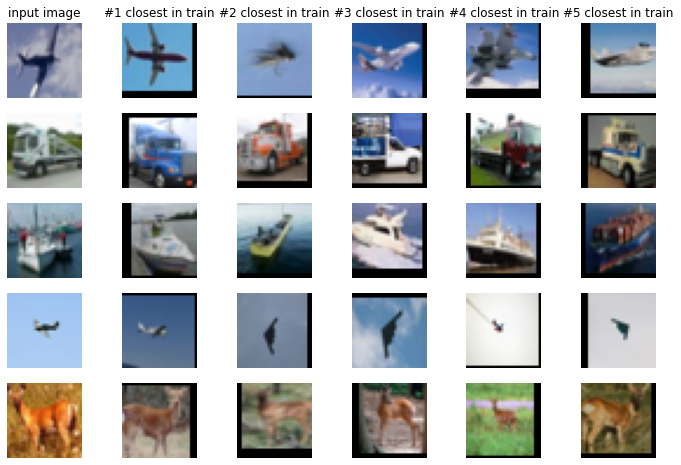

In [ ]:
n = 5
m = 5
train_val_set = trainset + valset

fig, axes = plt.subplots(nrows=n, ncols=m+1, figsize=(12, 8))

cols = ["input image", "#1 closest in train", "#2 closest in train",
        "#3 closest in train", "#4 closest in train", "#5 closest in train"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    
for i in range(n):
    for j in range(m+1):
        if j==0:
          im_np = x_l[i].permute(1, 2, 0).numpy()
          im_np = im_np * std + mean
          axes[i][j].imshow(im_np)
        else:
          im_np = train_val_set[near_indices[i][j-1]][0].permute(1, 2, 0).numpy()
          im_np = im_np * std + mean
          axes[i][j].imshow(im_np)
        axes[i][j].axis('off')

plt.show()

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
M = 2000

zipped = list(zip(train_feature_spaces, train_labels))
shuffle(zipped)
train_feature_spaces, train_labels = zip(*zipped)

sampled_l = []
sampled_labels = []

for i, fs in enumerate(train_feature_spaces):
  if i >= M:
    break
  sampled_l.append(fs)
  sampled_labels.append(train_labels[i])

sampled = torch.cat(sampled_l, 0)
sampled = torch.reshape(sampled, (M, N))

sampled.shape

torch.Size([2000, 400])

In [ ]:
embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random').fit_transform(sampled)

embedded.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

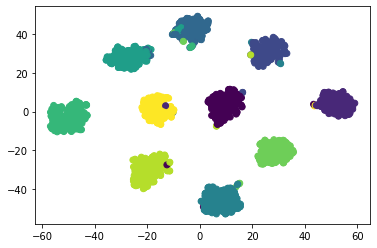

In [ ]:
x_l = [e[0] for e in embedded]
y_l = [e[1] for e in embedded]

plt.scatter(x_l,y_l,c=sampled_labels)
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from copy import deepcopy
from random import shuffle
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [3]:
class MyCustomDataset(Dataset):
    def __init__(self, train = False, download = True,
                 transform=transforms.ToTensor()):

        self.transform = transform
        self.dataset = torchvision.datasets.CIFAR10(root='./data', 
                                                    transform = None,
                                                    train=train,
                                                    download=download)
        self.bw_transform = transforms.Grayscale(num_output_channels = 3)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        colored_image = self.dataset[idx][0]
        colored_image = self.transform(colored_image)
        bw_image = self.bw_transform(colored_image)
        return bw_image, colored_image


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
trainset = MyCustomDataset(transform = transforms.ToTensor(),
                                        train=True,
                                        download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, (train_size, val_size))

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

In [8]:
n = 36
testset = MyCustomDataset(transform = transforms.ToTensor(),
                                        train=False,
                                        download=True)
testset_cropped = torch.utils.data.random_split(testset, (n, len(testset) - n))[0]
testloader = torch.utils.data.DataLoader(testset_cropped, batch_size=1024,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

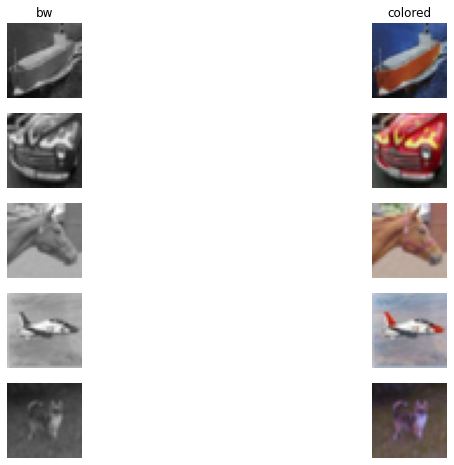

In [9]:
bw_images = []
colored_images = []
i = 0
n = 5
k = 5

while len(bw_images) < n*k:
    x, y = trainset[i]
    bw_images.append(x)
    colored_images.append(y)
    i += 1

temp = list(zip(bw_images, colored_images))
shuffle(temp)
bw_images, colored_images = zip(*temp)

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 8))

axes[0][0].set_title("bw")
axes[0][1].set_title("colored")

for j in range(n):
    axes[j][0].imshow(bw_images[j].permute(1, 2, 0).numpy())
    axes[j][1].imshow(colored_images[j].permute(1, 2, 0).numpy())
    axes[j][0].axis('off')
    axes[j][1].axis('off')

plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

*UNet with the following architecture is used.*

*There are a dropout layer and a batchnorm layer after each Maxpool and each ConvTranspose.*

*\[Conv->Conv->MaxPool] is performed two times instead of four to still have a reasonable resolution at the lowest part of the architecture.*

![Original-ResNet-18-Architecture.png](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.copy1 = None
        self.copy2 = None
        self.copy3 = None
        self.copy4 = None
        self.conv1 = nn.Sequential(              # 3   32  32
            nn.Conv2d(3, 64, 3, padding=1),     # 64  32  32
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU()
        )
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                 # 64  16  16
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(64)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),    # 128  16  16
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),    # 128  16  16
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                 # 128  8   8
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),    # 256  8  8
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),    # 256  8  8
            nn.ReLU()
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride = 2, padding = 1,
                               output_padding = 1) #128 16 16
        )
        self.conv4 = nn.Sequential(               # 256 16 16 
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, 3, padding=1),    # 128 16 16
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),    # 128 16 16
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1,
                               output_padding = 1) #64 32 32
        )
        self.conv5 = nn.Sequential(               # 128 32 32
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 3, padding=1),    # 64 32 32
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),    # 64 32 32
            nn.ReLU(),
            nn.Conv2d(64, 3, 1),       # 3 32 32
            nn.ReLU()
        )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        self.copy1 = torch.clone(x)
        #print(f"made copy1: {self.copy1.shape}")
        x = self.down1(x)
        x = self.conv2(x)
        self.copy2 = torch.clone(x)
        #print(f"made copy2: {self.copy2.shape}")
        x = self.down2(x)
        x = self.conv3(x)
        x = self.up1(x)
        x = torch.cat((x,self.copy2),dim = 1)
        #print(f"concat copy2: {x.shape}")
        x = self.conv4(x)
        x = self.up2(x)
        x = torch.cat((x,self.copy1), dim = 1)
        #print(f"concat copy1: {x.shape}")
        x = self.conv5(x)
        #print(x.shape)
        return x

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [11]:
net = UNet().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [12]:
lr = 1e-3

In [13]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

In [14]:
def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    train_loss = 0
    
    net.train()
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)

        loss = criterion(pred, y)
        train_loss += float(loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return train_loss

In [15]:
def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    val_loss = 0
    
    net.eval()
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)
        
        loss = criterion(pred, y)
        val_loss += float(loss)

    return val_loss

In [17]:
epochs = 100
train_loss_list = []
val_loss_list = []

for i in range(epochs):
    print(f"[Epoch {i}]")
    
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader)
    
    print(f"Train Loss: {train_loss}")
    print(f"Validation Loss: {val_loss}")
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)


[Epoch 0]
Train Loss: 1.9055842850357294
Validation Loss: 0.07239617127925158
[Epoch 1]
Train Loss: 0.5734111005440354
Validation Loss: 0.06560329860076308
[Epoch 2]
Train Loss: 0.552388537209481
Validation Loss: 0.06572819268330932
[Epoch 3]
Train Loss: 0.5455039814114571
Validation Loss: 0.06325016915798187
[Epoch 4]
Train Loss: 0.5320458021014929
Validation Loss: 0.06097478652372956
[Epoch 5]
Train Loss: 0.5101925083436072
Validation Loss: 0.06306256260722876
[Epoch 6]
Train Loss: 0.4955458645708859
Validation Loss: 0.06147760897874832
[Epoch 7]
Train Loss: 0.4816907737404108
Validation Loss: 0.0604843320325017
[Epoch 8]
Train Loss: 0.4754300191998482
Validation Loss: 0.061483667232096195
[Epoch 9]
Train Loss: 0.46656883461400867
Validation Loss: 0.060423280112445354
[Epoch 10]
Train Loss: 0.4638057821430266
Validation Loss: 0.06112570967525244
[Epoch 11]
Train Loss: 0.46266585448756814
Validation Loss: 0.0648591099306941
[Epoch 12]
Train Loss: 0.4549872768111527
Validation Loss: 0.

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

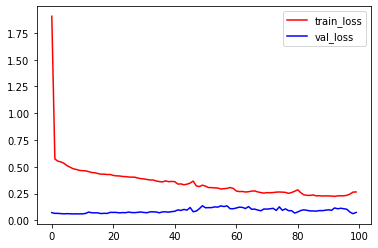

In [18]:
x = list(range(epochs))
plt.plot(x, train_loss_list, 'r')
plt.plot(x, val_loss_list, 'b') 
plt.legend(['train_loss', 'val_loss']) 

plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [19]:
def test_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    test_loss = 0
    preds = []

    net.eval()
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)

        preds.append(pred)
        
        loss = criterion(pred, y)
        test_loss += float(loss)

    return test_loss, preds

In [20]:
test_loss, preds = test_epoch(net, criterion, testloader)

In [21]:
torch.save(net.state_dict(), f"unet.pth") 

In [22]:
n = 36

x_l = []
y_l = []

for i,(x,y) in enumerate(testloader):
  x_l.append(x)
  y_l.append(y)

zipped = list(zip(x_l, y_l, preds))[0:n]
shuffle(zipped)
inputs, ground_truths, preds = zip(*zipped)
   

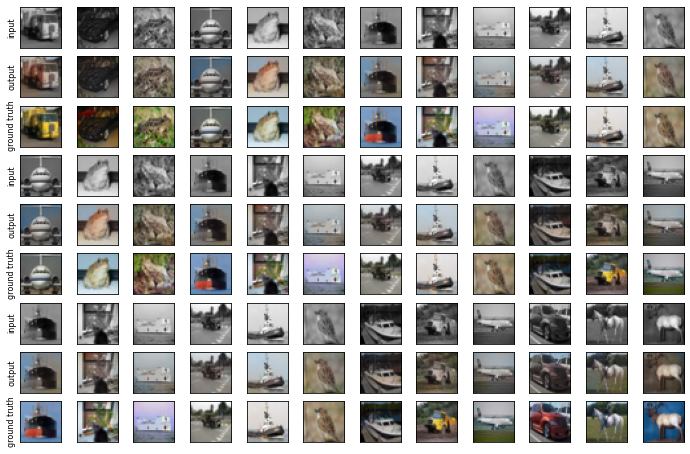

In [23]:
inputs = []
ground_truths = []
predictions = []

i = 0

for i, (x,y) in enumerate(testloader):
  for j in range(x.shape[0]):
    inputs.append(x[j].cpu().data)
    ground_truths.append(y[j].cpu().data)
    predictions.append(preds[0][j].cpu().data)

fig, axes = plt.subplots(nrows=9, ncols=12, figsize=(12, 8))

for i, row in enumerate(axes):
  if i % 3 == 0:
    row[0].set_ylabel("input", fontsize=8)
  elif i % 3 == 1:
    row[0].set_ylabel("output", fontsize=8)
  else:
    row[0].set_ylabel("ground truth", fontsize=8)

for i in range(3):
  for j in range(12):
    axes[3*i][j].imshow(inputs[3*i+j].permute(1, 2, 0).numpy())
    axes[3*i+1][j].imshow(predictions[3*i+j].permute(1, 2, 0).numpy())
    axes[3*i+2][j].imshow(ground_truths[3*i+j].permute(1, 2, 0).numpy())
    axes[3*i][j].set_xticks([])
    axes[3*i+1][j].set_xticks([])
    axes[3*i+2][j].set_xticks([])
    axes[3*i][j].set_yticks([])
    axes[3*i+1][j].set_yticks([])
    axes[3*i+2][j].set_yticks([])
    

plt.show()